
<h1 align=center><font size = 5> <center>文本分析与挖掘</center> </font></h1> 

<h2 align=center><font size = 4><center>实验八、基于 TextCNN 的中文情感分析</center></font></h2>
<h2 align=center><font size = 2><center>浙江工业大学计算机科学与技术学院</center></font></h2>

## 一、实验目的

<div class="alert alert-block alert-info" style="margin-top: 20px">
<li>理解 CNN 网络在文本任务中的用法</li>
<li>掌握 tensorflow 搭建文本分类模型的方法</li>
<li>熟悉中文情感分析过程。</li>

## 二、实验内容
<div class="alert alert-block alert-info" style="margin-top: 20px">
<li>预处理</li>
<li>设置模型</li>
<li>训练模型</li>
<li>测试模型</li>


In [1]:
import jieba
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
import unicodedata
import matplotlib.pyplot as plt

### 1.预训练

#### a. 加载数据（训练集 train.tsv，测试集 test.tsv，验证集 dev.tsv）,适当预处理、分词后构建词汇表以及对应索引，留出索引0:padding，1：unknown

In [2]:
train_data = pd.read_csv('data/train.tsv', sep='\t')
valid_data = pd.read_csv('data/dev.tsv', sep='\t')
test_data = pd.read_csv('data/test.tsv', sep='\t') 
x_train, y_train = train_data.text_a.values, train_data.label.values # 训练集
x_valid, y_valid = valid_data.text_a.values, valid_data.label.values # 验证集
x_test, y_test = test_data.text_a.values, test_data.label.values # 测试集

In [14]:
#数字对情感分类作用不大，应去除
#判断是否为数字
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        pass
 
    try:
        unicodedata.numeric(s)
        return True
    except (TypeError, ValueError):
        pass
    return False


In [22]:
#构建词汇表
vocab = set()
cut_docs = train_data.text_a.apply(lambda x: jieba.cut(x)).values
for doc in cut_docs:
    for word in doc:
        if word.strip():
            if is_number(word.strip())==False:#不为数字，填入词汇表
                vocab.add(word.strip())
                
# 将词表写入本地vocab.txt文件
with open('data/vocab.txt', 'w') as file:
    for word in  vocab:
        file.write(word)
        file.write('\n')


In [3]:
#配置类
class Config():
    def __init__(self,embedding_dim, max_seq_len):
        self.embedding_dim = embedding_dim # 词向量维度
        self.max_seq_len = max_seq_len # 文章长度
        self.vocab_file = 'data/vocab.txt' # 词汇表文件路径

#预处理类
class Preprocessor():
    def __init__(self, config):
        self.config = config
        # 初始化词和id的映射词典，预留0给padding字符，1给词表中未见过的词
        token2idx = {"[PAD]": 0, "[UNK]": 1} # {word：id}
        with open(config.vocab_file, 'r') as reader:
            for index, line in enumerate(reader):
                token = line.strip()
                token2idx[token] = index+2
                
        self.token2idx = token2idx
        
    def transform(self, text_list):
        # 文本分词，并将词转换成相应的id, 最后不同长度的文本padding长统一长度，后面补0
        idx_list = [[self.token2idx.get(word.strip(), self.token2idx['[UNK]']) for word in jieba.cut(text)] for text in text_list]
        idx_padding = pad_sequences(idx_list, self.config.max_seq_len, padding='post')
        
        return idx_padding

#### b.把每个句子/评论转成长度统一为 max_len=100 的向量，太长的截断，太短的后面补零。

In [4]:
config1 = Config(200,100)#词向量维度=200,句长为100
preprocessor1 = Preprocessor(config1)

In [5]:
x_train=preprocessor1.transform(x_train)
x_valid=preprocessor1.transform(x_valid)
x_test=preprocessor1.transform(x_test)

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\DELL\AppData\Local\Temp\jieba.cache
Loading model cost 0.747 seconds.
Prefix dict has been built successfully.


#### c.打印两个样本查看结果。

In [28]:
print(len(x_train[0]))

100


In [27]:
x_train[0:2]

array([[34200,  9998, 11501, 17393, 10099,  4421, 22925,  4747,  4388,
        20174,  2692, 29750,  6785, 18439,  4747, 34155, 21572,  7668,
        31278,  7668, 26554,  7668,  1684,  7668,  7148,  6997,  2878,
        15585, 33671,  8784,  4747, 30819, 31366,   366, 18690,  2878,
            1, 23792, 33544,  4911, 17393, 20903,  4747, 10762, 31393,
         4747, 24678, 10845, 28838, 20639, 13694,  2878,     1, 25162,
        17393, 32022, 20639, 27288, 17393,  4747, 31366,   366,  1160,
         2878,     1, 21080, 33584,  4747,  8784,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0],
       [    1, 24203, 15705, 17393,  2638, 22269, 28383,  4747, 23274,
        24927,  8097, 21488,   682,  4747,  9183, 13694,  2017, 19475,
         4747, 30860,  2017, 19354, 22925,  4747,  7793, 3217

### 2.设置模型

 - a.设置 embedding 层输出维度 embed_dim=200；
 - b.卷积层设置三种卷积核大小 kernel_size=[2,3,4]，每种大小用64 个卷积核，即 filters=64；
 - c.倒数第二的全连接 dense 层输出 64 维，Relu 激活；
 - d.最后一个输出二分类结果，1 个节点，sigmoid 激活。
 

In [34]:
class TextCNN(object):
    def __init__(self, config):
        self.config = config
        self.preprocessor = Preprocessor(config)
        self.class_name = {0: '负面', 1: '正面'}
    
    def build_model(self):
        # 模型架构搭建
        idx_input = tf.keras.layers.Input((self.config.max_seq_len,))
        input_embedding = tf.keras.layers.Embedding(len(self.preprocessor.token2idx),
                    self.config.embedding_dim,
                    input_length=self.config.max_seq_len,
                    mask_zero=True)(idx_input)
        convs = []
        for kernel_size in [2, 3, 4]:
            c = tf.keras.layers.Conv1D(64, kernel_size, activation='relu')(input_embedding)
            c = tf.keras.layers.GlobalMaxPooling1D()(c)
            convs.append(c)
        fea_cnn = tf.keras.layers.Concatenate()(convs)
        fea_cnn_dropout = tf.keras.layers.Dropout(rate=0.4)(fea_cnn)
        
        fea_dense = tf.keras.layers.Dense(64, activation='relu')(fea_cnn_dropout)
        output = tf.keras.layers.Dense(1, activation='sigmoid')(fea_dense)
        
        model = tf.keras.Model(inputs=idx_input, outputs=output)
        model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
        
        model.summary()
        
        self.model = model
    
    def fit(self, x_train, y_train, x_valid=None, y_valid=None, epochs=5, batch_size=128, callbacks=None, **kwargs):
        # 训练
        valid_data = None
        if x_valid is not None and y_valid is not None:
            valid_data = (x_valid, y_valid)

        self.history=self.model.fit(
            x=x_train,
            y=y_train,
            validation_data= valid_data,
            batch_size=batch_size,
            epochs=epochs,
            callbacks=callbacks,
            **kwargs
        )
        
    def evaluate(self, x_test, y_test):
        # 评估
        y_pred_probs = self.model.predict(x_test)
        y_pred = np.round(y_pred_probs)
        result = classification_report(y_test, y_pred, target_names=['负面', '正面'])
        print(result)
        
        
    def single_predict(self, text):
        # 预测
        input_idx = self.preprocessor.transform([text])
        predict_prob = self.model.predict(input_idx)[0]
        predict_label_id = np.round(predict_prob)
        
        predict_label_name = self.class_name[predict_label_id]
        predict_label_prob = predict_prob[predict_label_id]
        
        return predict_label_name, predict_label_prob
    
    def load_model(self, ckpt_file):
        self.build_model()
        self.model.load_weights(ckpt_file)

#### 打印模型参数

In [35]:
textcnn = TextCNN(config1)
textcnn.build_model()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 100, 200)     6877200     input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 99, 64)       25664       embedding_4[0][0]                
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 98, 64)       38464       embedding_4[0][0]                
_______________________________________________________________________________________

### 3.训练模型

#### a.设置损失函数、epoch、优化器、学习率等超参数并训练模型。

In [36]:
# 定义early stop早停回调函数
patience = 8
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)

# 定义checkpoint回调函数
checkpoint_prefix = './checkpoints/textcnn_imdb_ckpt'
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True,
    save_best_only=True)

In [37]:
textcnn.fit(x_train, y_train, x_valid, y_valid, epochs=50, callbacks=[early_stop, checkpoint_callback]) # 训练

Epoch 1/50
72/72 [==============================] - 4s 59ms/step - loss: 0.5864 - accuracy: 0.6942 - val_loss: 0.4343 - val_accuracy: 0.8000
Epoch 2/50
72/72 [==============================] - 4s 57ms/step - loss: 0.3042 - accuracy: 0.8801 - val_loss: 0.2777 - val_accuracy: 0.8975
Epoch 3/50
72/72 [==============================] - 5s 69ms/step - loss: 0.1305 - accuracy: 0.9578 - val_loss: 0.2630 - val_accuracy: 0.9083
Epoch 4/50
72/72 [==============================] - 4s 54ms/step - loss: 0.0549 - accuracy: 0.9857 - val_loss: 0.2928 - val_accuracy: 0.8975
Epoch 5/50
72/72 [==============================] - 4s 55ms/step - loss: 0.0341 - accuracy: 0.9913 - val_loss: 0.3354 - val_accuracy: 0.8950
Epoch 6/50
72/72 [==============================] - 4s 54ms/step - loss: 0.0236 - accuracy: 0.9938 - val_loss: 0.3424 - val_accuracy: 0.9042
Epoch 7/50
72/72 [==============================] - 4s 54ms/step - loss: 0.0239 - accuracy: 0.9943 - val_loss: 0.3656 - val_accuracy: 0.8975
Epoch 8/50
72

#### b.打印并观察模型的学习曲线，讨论训练情况。

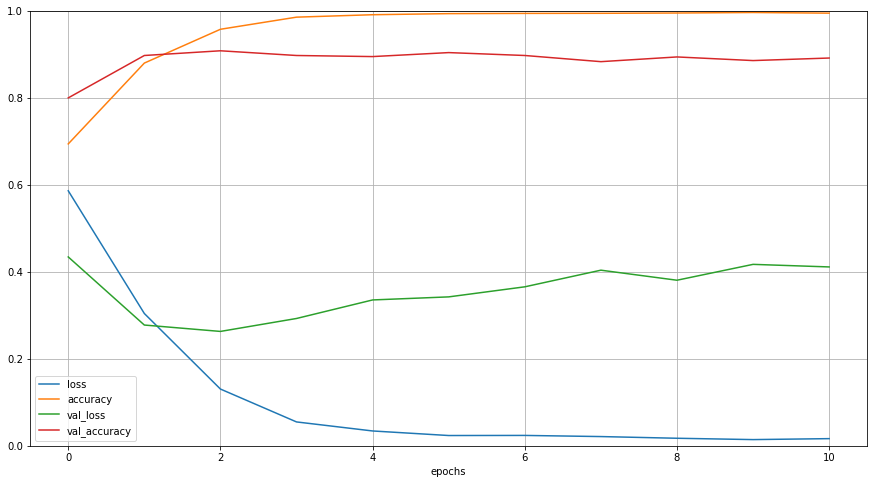

In [39]:
pd.DataFrame(textcnn.history.history).plot(figsize=(15,8))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.xlabel("epochs")
plt.show()

#### 测试集准确率

In [38]:
textcnn.evaluate(x_test,y_test)

              precision    recall  f1-score   support

          负面       0.89      0.93      0.91       592
          正面       0.93      0.89      0.91       608

    accuracy                           0.91      1200
   macro avg       0.91      0.91      0.91      1200
weighted avg       0.91      0.91      0.91      1200



<div class="alert alert-success alertsuccess" style="margin-top: 10px">
结果分析和讨论：
从训练数据来看，验证集的准确率在第2个epoch就开始到达峰值，训练集的准确率随着epoch的增加而接近于1，有过拟合的趋势。
    
总体模型的性能较好，测试集的f1-socre值平均有0.91。

#### c.基于以上观察适当调整实验设置（超参数、网络结构），对比结果。

- 调整词向量维度为400，句长为300
- 调整模型结构，使用4个一维卷积，卷积核大小 kernel_size=[2,3,4,5]，每个卷积层有128 个卷积核
- 调整最后一层为2个节点，使用softmax来实现二分类
- 调整dropout层比例为0.6

In [49]:
config2 = Config(200,100)#词向量维度=400,句长为300
preprocessor2 = Preprocessor(config2)

x_train=preprocessor1.transform(x_train)
x_valid=preprocessor1.transform(x_valid)
x_test=preprocessor1.transform(x_test)

In [50]:
class TextCNN2(object):
    def __init__(self, config):
        self.config = config
        self.preprocessor = Preprocessor(config)
        self.class_name = {0: '负面', 1: '正面'}
    
    def build_model(self):
        # 模型架构搭建
        idx_input = tf.keras.layers.Input((self.config.max_seq_len,))
        input_embedding = tf.keras.layers.Embedding(len(self.preprocessor.token2idx),
                    self.config.embedding_dim,
                    input_length=self.config.max_seq_len,
                    mask_zero=True)(idx_input)
        convs = []
        for kernel_size in [2, 3, 4, 5]:
            c = tf.keras.layers.Conv1D(128, kernel_size, activation='relu')(input_embedding)
            c = tf.keras.layers.GlobalMaxPooling1D()(c)
            convs.append(c)
        fea_cnn = tf.keras.layers.Concatenate()(convs)
        fea_cnn_dropout = tf.keras.layers.Dropout(rate=0.6)(fea_cnn)
        
        fea_dense = tf.keras.layers.Dense(64, activation='relu')(fea_cnn_dropout)
        output = tf.keras.layers.Dense(2, activation='softmax')(fea_dense)
        
        model = tf.keras.Model(inputs=idx_input, outputs=output)
        model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
        
        model.summary()
        
        self.model = model
    
    def fit(self, x_train, y_train, x_valid=None, y_valid=None, epochs=5, batch_size=128, callbacks=None, **kwargs):
        # 训练
        valid_data = None
        if x_valid is not None and y_valid is not None:
            valid_data = (x_valid, y_valid)

        self.history=self.model.fit(
            x=x_train,
            y=y_train,
            validation_data= valid_data,
            batch_size=batch_size,
            epochs=epochs,
            callbacks=callbacks,
            **kwargs
        )
        
    def evaluate(self, x_test, y_test):
        # 评估
        y_pred_probs = self.model.predict(x_test)
        y_pred = np.argmax(y_pred_probs, axis=-1)
        result = classification_report(y_test, y_pred, target_names=['负面', '正面'])
        print(result)
        
        
    def single_predict(self, text):
        # 预测
        input_idx = self.preprocessor.transform([text])
        predict_prob = self.model.predict(input_idx)[0]
        predict_label_id = np.argmax(predict_prob)
        
        predict_label_name = self.class_name[predict_label_id]
        predict_label_prob = predict_prob[predict_label_id]
        
        return predict_label_name, predict_label_prob
    
    def load_model(self, ckpt_file):
        self.build_model()
        self.model.load_weights(ckpt_file)

In [52]:
textcnn2 = TextCNN2(config2)
textcnn2.build_model()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 100, 200)     6877200     input_6[0][0]                    
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 99, 128)      51328       embedding_5[0][0]                
__________________________________________________________________________________________________
conv1d_16 (Conv1D)              (None, 98, 128)      76928       embedding_5[0][0]                
_______________________________________________________________________________________

In [53]:
# 定义early stop早停回调函数
patience = 8
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)

# 定义checkpoint回调函数
checkpoint_prefix = './checkpoints2/textcnn_imdb_ckpt'
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True,
    save_best_only=True)

textcnn2.fit(x_train, y_train, x_valid, y_valid, epochs=50, callbacks=[early_stop, checkpoint_callback]) # 训练



Epoch 1/50
72/72 [==============================] - 6s 77ms/step - loss: 0.5801 - accuracy: 0.6872 - val_loss: 0.4167 - val_accuracy: 0.8183
Epoch 2/50
72/72 [==============================] - 5s 71ms/step - loss: 0.2946 - accuracy: 0.8801 - val_loss: 0.2807 - val_accuracy: 0.8983
Epoch 3/50
72/72 [==============================] - 5s 68ms/step - loss: 0.1314 - accuracy: 0.9567 - val_loss: 0.3118 - val_accuracy: 0.8900
Epoch 4/50
72/72 [==============================] - 5s 68ms/step - loss: 0.0579 - accuracy: 0.9833 - val_loss: 0.3256 - val_accuracy: 0.9042
Epoch 5/50
72/72 [==============================] - 5s 72ms/step - loss: 0.0344 - accuracy: 0.9926 - val_loss: 0.3626 - val_accuracy: 0.8975
Epoch 6/50
72/72 [==============================] - 5s 69ms/step - loss: 0.0249 - accuracy: 0.9937 - val_loss: 0.3930 - val_accuracy: 0.8950
Epoch 7/50
72/72 [==============================] - 5s 68ms/step - loss: 0.0223 - accuracy: 0.9945 - val_loss: 0.3945 - val_accuracy: 0.9025
Epoch 8/50
72

In [54]:
textcnn2.evaluate(x_test,y_test)

              precision    recall  f1-score   support

          负面       0.86      0.91      0.88       592
          正面       0.91      0.86      0.88       608

    accuracy                           0.88      1200
   macro avg       0.88      0.88      0.88      1200
weighted avg       0.88      0.88      0.88      1200



<div class="alert alert-success alertsuccess" style="margin-top: 10px">
结果分析和讨论：
进行相关调整后，f1-score值有略微下降，模型性能和之前比略微差了一点。

### 4.测试模型

#### a.自己写一条评论文本数据进行测试，输出情感类别及其概率;

In [7]:
checkpoint_prefix = './checkpoints/textcnn_imdb_ckpt'
textcnn = TextCNN(config1)
textcnn.load_model(checkpoint_prefix)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 200)     6877200     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 99, 64)       25664       embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 98, 64)       38464       embedding[0][0]                  
_______________________________________________________________________________________

In [9]:
textcnn.single_predict("东西很好，孩子很喜欢，已经买了3箱了") # 单句预测

('正面', 0.7965236)

In [10]:
textcnn.single_predict("什么东西啊，产品与描述不一致") # 单句预测

('负面', 0.8643537)